In [1]:
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import tensorflow as tf
import torch 
import torchvision

os.system('pip install iterative-stratification==0.1.7')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/fb3-my-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/fb3-my-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Found existing installation: transformers 4.20.1
Uninstalling transformers-4.20.1:
  Successfully uninstalled transformers-4.20.1


Found existing installation: tokenizers 0.12.1
Uninstalling tokenizers-0.12.1:
  Successfully uninstalled tokenizers-0.12.1


Looking in links: ../input/fb3-my-pip-wheels
Processing /kaggle/input/fb3-my-pip-wheels/transformers-4.21.2-py3-none-any.whl
Processing /kaggle/input/fb3-my-pip-wheels/tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires transformers<4.21,>=4.1, but you have transformers 4.21.2 which is incompatible.


Looking in links: ../input/fb3-my-pip-wheels


tokenizers.__version__: 0.12.1
transformers.__version__: 4.21.2
env: TOKENIZERS_PARALLELISM=true


In [2]:
BASE_PATH = '/kaggle/input/feedback-prize-english-language-learning'
SUBMISSION_PATH = os.path.join(BASE_PATH, 'sample_submission.csv')
TRAIN_PATH = os.path.join(BASE_PATH, 'train.csv')
TEST_PATH = os.path.join(BASE_PATH, 'test.csv')

In [3]:
def get_logger(filename='inference'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.propagate = False
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

In [4]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
    def init(self, kwargs):
        super().init(kwargs)

        for k, v in kwargs.items():
            setattr(self, k, v)

    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

* epochs: 8
* encoder_lr: 3e-5
* layerwise_learning_rate_decay: 0.8

In [5]:
CFG = Config(
    debug=False,

    ####################

    apex=True,
    num_workers=4,
    model='microsoft/deberta-v3-base',
    model_type='deberta_v3',
    gradient_checkpointing=True,
    scheduler='cosine',
    batch_scheduler=True,

    # for cosine
    num_cycles=0.5,
    # for linear
    warm_up_ratio=0.06,
    
    ####################

    epochs=8,
    val_ratio=1.0,
    batch_size=8,
    max_len=512,

    ####################

    ap_hidden_size=512,

    reinit_last_layer=True,
    reinit_fc=True,

    exponential_gamma=0.3,

    weight_decay=0.01,
    encoder_lr=3e-5,
    decoder_lr=1e-4,
    layerwise_learning_rate_decay=0.8,

    eps=1e-6,
    betas=(0.9, 0.999),

    use_dropout=False,
    prob_dropout=[0.06, 0.08, 0.1, 0.12, 0.14],
    num_dropout=5,

    use_awp=False,
    awp_start_epoch=0,
    awp_adv_lr=1e-2, 
    awp_adv_eps=1e-3,
    
    ####################
    
    gradient_accumulation_steps=1,
    max_grad_norm=1000,
    target_cols=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'],

    num_target=6,
    seed=42,
    n_fold=4,
    trn_fold=[0,1,2,3],
    train=True
)
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [6]:
OUTPUT_DIR = './'
cfg_json = json.dumps(CFG)
with open(os.path.join(OUTPUT_DIR, 'CFG.json'), 'w') as f:
    f.write(cfg_json)



---



In [7]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
submission = pd.read_csv(SUBMISSION_PATH)

if CFG.debug:
    train = train.head(1000)

mskfold = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_idx, val_idx) in enumerate(mskfold.split(train, train[CFG.target_cols])):
    train.loc[val_idx, 'fold'] = int(n)

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.history = []

    def update(self, val, n=1):
        self.val = val
        self.history.append(val)
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


# dataset

In [9]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model, use_fast=True)
tokenizer.save_pretrained(os.path.join(OUTPUT_DIR, 'tokenizer'))
CFG.tokenizer = tokenizer
CFG.max_len = 1024

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# model

In [10]:
class AWP:
    def __init__(self, model, optimizer, *, adv_param='weight',
                 adv_lr=0.001, adv_eps=0.001):
        self.model = model
        self.optimizer = optimizer
        self.adv_param = adv_param
        self.adv_lr = adv_lr
        self.adv_eps = adv_eps
        self.backup = {}

    def perturb(self, input_ids, attention_mask, y, criterion):
        """
        Perturb model parameters for AWP gradient
        Call before loss and loss.backward()
        """
        self._save()  # save model parameters
        self._attack_step()  # perturb weights

    def _attack_step(self):
        e = 1e-6
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                # grad = self.optimizer.state[param]['exp_avg']
                grad = param.grad
                norm_grad = torch.norm(grad)
                norm_data = torch.norm(param.detach())

                if norm_grad != 0 and not torch.isnan(norm_grad):
                    # Set lower and upper limit in change
                    limit_eps = self.adv_eps * param.detach().abs()
                    param_min = param.data - limit_eps
                    param_max = param.data + limit_eps

                    # Perturb along gradient
                    # w += (adv_lr * |w| / |grad|) * grad
                    param.data.add_(grad, alpha=(self.adv_lr * (norm_data + e) / (norm_grad + e)))

                    # Apply the limit to the change
                    param.data.clamp_(param_min, param_max)

    def _save(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                if name not in self.backup:
                    self.backup[name] = param.clone().detach()
                else:
                    self.backup[name].copy_(param.data)

    def restore(self):
        """
        Restore model parameter to correct position; AWP do not perturbe weights, it perturb gradients
        Call after loss.backward(), before optimizer.step()
        """
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data.copy_(self.backup[name])

In [11]:
def seed_everything(seed=42):
    random.seed(seed)
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # When running on the CuDNN backend, two further options must be set
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed_everything(seed=CFG.seed)

def mc_rmse(y_true, y_pred):
    scores = []
    ncols = y_true.shape[1]
    
    for n in range(ncols):
        yn_true = y_true[:, n]
        yn_pred = y_pred[:, n]
        rmse_ = mean_squared_error(yn_true, yn_pred, squared=False)
        scores.append(rmse_)
    score = np.mean(scores) 
    return score, scores

In [12]:
def encode_text(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=cfg.max_len,
        pad_to_max_length=True,
        truncation=True)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs 

def collate(inputs):
    # Trimming input.
    mask_len = int(inputs['attention_mask'].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['full_text'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = encode_text(self.cfg, self.texts[item])
        return inputs

class TrainDataset(Dataset):
    def __init__(self, cfg, data):
        self.cfg = cfg
        self.xs = data['full_text']
        self.ys = data[cfg.target_cols].values 
        #self.features = data[FEATURE_COLS].values
        
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        x = encode_text(self.cfg, self.xs[idx])
        #features = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.ys[idx], dtype=torch.float32)
        return x, y

def create_data_loaders(cfg, folds, fold):
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    train_dataset = TrainDataset(cfg, train_folds)
    valid_dataset = TrainDataset(cfg, valid_folds)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True,
        drop_last=True
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True,
        drop_last=False
    )
    return train_loader, valid_loader

In [13]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
    
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 9, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, all_hidden_states):
        all_layer_embedding = all_hidden_states[self.layer_start:, :, :, :]
        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()
        return weighted_average
        
class MultiSampleDropout(nn.Module):
    def __init__(self, fc, num_dropout, prob_dropout):
        super(MultiSampleDropout, self).__init__()
        self.dropout = nn.Dropout
        self.num_dropout = num_dropout
        self.prob_dropout = prob_dropout
        self.classifier = fc
    def forward(self, out):
        if not type(self.prob_dropout) in [float, int]:            
            fcs = [self.classifier(self.dropout(p)(out)) for p in self.prob_dropout]
        else:
            fcs = [self.classifier(self.dropout(self.prob_dropout)(out)) for _ in range(self.num_dropout)]
        return torch.mean(torch.stack(fcs, dim=0), dim=0)

class AttentionPooling(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.attention = nn.Sequential(
        nn.Linear(in_dim, in_dim),
        nn.LayerNorm(in_dim),
        nn.GELU(),
        nn.Linear(in_dim, 1),
        )

    def forward(self, last_hidden_state, attention_mask):
        w = self.attention(last_hidden_state).float()
        w[attention_mask==0]=float('-inf')
        w = torch.softmax(w,1)
        attention_embeddings = torch.sum(w * last_hidden_state, dim=1)
        return attention_embeddings

In [14]:
class FB3Model(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg 
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            # Turn off dropouts.
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            #LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)

        if self.cfg.reinit_last_layer:
            # Re-init last layer of deberta.
            for module in self.model.encoder.layer[-1:].modules():
                self._init_weights(module)
        self.model.gradient_checkpointing_enable()

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

class WeightedAttentionModel(FB3Model):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__(cfg, config_path=config_path, pretrained=pretrained)

        self.weighted_pool = WeightedLayerPooling(
            self.config.num_hidden_layers, layer_start=9, layer_weights=None)
        self.att_pool = AttentionPooling(self.config.hidden_size)

        self.fc_out = nn.Linear(self.config.hidden_size*2, cfg.num_target)
        self._init_weights(self.fc_out)

    def forward(self, x):
        pt_out = self.model(**x)
        hidden_states = pt_out.hidden_states
        last_hidden_state = pt_out.last_hidden_state

        x1 = self.weighted_pool(torch.stack(hidden_states))[:, 0]
        x2 = self.att_pool(last_hidden_state, x['attention_mask'])

        y_hat = self.fc_out(torch.cat([x1, x2], dim=1))
        return y_hat

In [15]:
def get_optimizer(
    model, 
    cfg,
    model_type='model',
):
    no_decay = ['bias', 'LayerNorm.weight']
    
    all_layers = [(n,p) for n,p in model.model.named_parameters() if 'embeddings' == n.split('.')[0]] + [(n,p) for n,p in model.model.named_parameters() if 'encoder' == n.split('.')[0]]
    all_layers.reverse()
    group_all=['layer.0.','layer.1.','layer.2.','layer.3.','layer.4.','layer.5.','layer.6.','layer.7.','layer.8.','layer.9.','layer.10.','layer.11.']
    group_all.reverse()

    optimizer_grouped_parameters = []

    # Encoder layers
    #LOGGER.info('Applying layerwise learning decay...')
    for i, layer_idx in enumerate(group_all):
        lr = cfg.encoder_lr * cfg.layerwise_learning_rate_decay
        optimizer_grouped_parameters.append({'params': [p for n,p in all_layers if not any(nd in n for nd in no_decay) and layer_idx in n], 'weight_decay': cfg.weight_decay, 'lr': lr})
        optimizer_grouped_parameters.append({'params': [p for n,p in all_layers if any(nd in n for nd in no_decay) and layer_idx in n], 'weight_decay': 0.0, 'lr': lr})
        #LOGGER.info(f'>>>>{layer_idx}     lr:{lr}')
                
    # Embeddings.
    optimizer_grouped_parameters.append({'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay) and not any(nd in n for nd in group_all)], 'weight_decay': cfg.weight_decay})
    optimizer_grouped_parameters.append({'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay) and not any(nd in n for nd in group_all)],'weight_decay': 0.0})

    # Regression head.
    optimizer_grouped_parameters.append({'params': [p for n, p in model.named_parameters() if model_type not in n], 'lr': cfg.decoder_lr, 'weight_decay': 0.0})
        
    optimizer = AdamW(optimizer_grouped_parameters, lr=cfg.encoder_lr, eps=cfg.eps, betas=cfg.betas)
        
    return optimizer

def get_optimizer(
    model, 
    cfg):
        
    no_decay = ['bias', 'LayerNorm.weight']

    # initialize lr for task specific layer
    optimizer_grouped_parameters = [{
        "params": [p for n, p in model.named_parameters() if "model" not in n],
        "weight_decay": 0.0,
        "lr": cfg.encoder_lr,
        }]

    # initialize lrs for every layer
    layers = [model.model.embeddings] + list(model.model.encoder.layer)
    layers.reverse()
    lr = cfg.encoder_lr
    
    for layer in layers:
        optimizer_grouped_parameters += [
            {"params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": cfg.weight_decay, "lr": lr},
            {"params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0, "lr": lr}
        ]
        lr *= cfg.layerwise_learning_rate_decay

    optimizer = AdamW(optimizer_grouped_parameters, lr=cfg.encoder_lr, eps=cfg.eps, betas=cfg.betas)
    return optimizer

def get_scheduler(cfg, optimizer, num_train_steps): 
    num_warmup_steps = int(cfg.warm_up_ratio * num_train_steps)
    
    if cfg.scheduler == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps
        )
    elif cfg.scheduler == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
        )
    elif cfg.scheduler == 'exponential':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=cfg.exponential_gamma)
    return scheduler

# train

In [16]:
def train_fn(fold, train_loader, valid_loader, model, loss_fn, optimizer, epoch, scheduler, device, best_score, awp_start=False, awp=None):
    model.train()
    
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    train_losses = AverageMeter()
    
    pbar = tqdm(train_loader)
    steps = len(train_loader)
    val_freq = int(model.cfg.val_ratio * len(train_loader))

    grad_norm = float('inf')
    valid_loss = float('inf')
    score = float('inf')
    
    for step, (inputs, labels) in enumerate(pbar):
        pbar.set_description(f'[TRAIN] Epoch {epoch+1}')
        
        # Trim input for faster training.
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
    
        labels = labels.to(device)
        batch_size = labels.size(0)
        
        # AWP
        #if awp and epoch >= model.cfg.awp_start:
        if awp_start:
            awp.perturb(inputs['input_ids'], inputs['attention_mask'],
                        labels, loss_fn)

        # Forward pass.
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
            loss = loss_fn(y_preds, labels)
            
        if CFG.gradient_accumulation_steps > 1:
            # normalize loss to account for batch accumulation
            loss = loss / CFG.gradient_accumulation_steps
        
        # Backward pass.
        train_losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        if awp_start:
            awp.restore()
        
        if (step + 1) % CFG.gradient_accumulation_steps == 0 or (step+1) == steps:
            # Unscales the gradients of optimizer's assigned params in-place
            scaler.unscale_(optimizer)
            
            # Weights update.
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)

            scaler.step(optimizer)
            scaler.update()
            
            optimizer.zero_grad()
            if CFG.batch_scheduler:
                scheduler.step()
        
        loss_cur = train_losses.val 
        loss_avg = train_losses.avg 
        lr=scheduler.get_lr()[0]

        pbar.set_postfix_str(f'loss_cur: {loss_cur:.4f};  loss_avg: {loss_avg:.4f};   grad: {grad_norm:.4f};   lr: {lr:.8f};    awp: {awp_start}')

        # Validation.
        if (step + 1) % val_freq == 0 or (step+1) == steps:
            valid_loss, score, best_score = valid_fn(fold, valid_loader, model, loss_fn, device, best_score)
        
        del inputs, labels, y_preds; gc.collect(); torch.cuda.empty_cache();
        
    return train_losses, valid_loss, score, best_score

def valid_fn(fold, valid_loader, model, loss_fn, device, best_score):
    valid_preds = []
    valid_labels = []
    losses = AverageMeter()
    model.eval()

    for step, (inputs, labels) in enumerate(valid_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        valid_labels.append(labels.to('cpu').numpy())
        labels = labels.to(device)
        batch_size = labels.size(0)
        
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=CFG.apex):
                y_preds = model(inputs)
                loss = loss_fn(y_preds, labels)    
        losses.update(loss.item(), batch_size)
        valid_preds.append(y_preds.to('cpu').numpy())

        del inputs, labels, y_preds; gc.collect(); torch.cuda.empty_cache();

    valid_preds = np.concatenate(valid_preds)
    valid_labels = np.concatenate(valid_labels)
    score, scores = mc_rmse(valid_labels, valid_preds)

    LOGGER.info('\n')
    LOGGER.info(f'[EVAL] score: {score:.4f};  scores: {scores}')
    if best_score > score:
        best_score = score
        LOGGER.info(f'>>>>>| 🌟🌟🌟🌟🌟 New best score: {best_score:.4f}')
        torch.save(
            {'model': model.state_dict(), 'valid_preds': valid_preds},
            OUTPUT_DIR + f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        
    del valid_preds, valid_labels; gc.collect(); torch.cuda.empty_cache();

    return losses.avg, score, best_score

def plot_metrics(df):
    f, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax = ax.ravel()
    
    df[['val_loss', 'train_loss']].plot(ax=ax[0])
    df[['val_score']].plot(ax=ax[1])

    plt.show()
    return f

In [17]:
def train_loop(cfg, model, folds, fold):
    history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'val_score': []
    }
    LOGGER.info(f'========== Fold: {fold} training ==========')
    
    # DATA LOADER
    train_loader, valid_loader = create_data_loaders(cfg, folds, fold)
    
    # CREATE MODEL
    torch.save(model.config, os.path.join(OUTPUT_DIR, 'config.pth'))
    model.to(device)
    
    # OPTIMIZER
    optimizer = get_optimizer(
       model,
       cfg,
    )

    # AWP
    awp = AWP(model, optimizer, adv_lr=cfg.awp_adv_lr, adv_eps=cfg.awp_adv_eps)

    # LEARNING RATE SCHEDULER
    num_train_steps = int(len(train_loader) * CFG.epochs)
    scheduler = get_scheduler(cfg, optimizer, num_train_steps)
    
    # LOSS FUNCTION
    loss_fn = nn.SmoothL1Loss(reduction='mean')
    train_loss_history = []
    best_score = np.inf
    for epoch in range(cfg.epochs):
        awp_start = epoch >= cfg.awp_start_epoch and cfg.use_awp
        train_losses, valid_loss, val_score, best_score = train_fn(
            fold, 
            train_loader, 
            valid_loader,
            model, 
            loss_fn, 
            optimizer, 
            epoch, 
            scheduler, 
            device,
            best_score)
        
        train_loss = train_losses.avg
        train_loss_history.extend(train_losses.history)
        LOGGER.info('====================================================')
        LOGGER.info(f'>>>>>Epoch {epoch+1}')
        LOGGER.info(f'>>>>>| avg_train_loss: {train_loss:.4f};  avg_val_loss: {valid_loss:.4f}')
        
        # Track metrics.
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(valid_loss)
        history['val_score'].append(val_score)
        LOGGER.info('====================================================')


    # History and plots.
    history = pd.DataFrame(history).set_index('epoch')
    f = plot_metrics(history)
    f.savefig(OUTPUT_DIR + f'fold{fold}.png', dpi=300)
    history['fold'] = fold

    f = pd.DataFrame(train_loss_history, columns=['train_loss']).plot().get_figure()
    f.savefig(OUTPUT_DIR + f'fold{fold}_train_loss.png', dpi=300)
    plt.show()

    predictions = torch.load(
        OUTPUT_DIR + f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
        map_location=torch.device('cpu'))['valid_preds']
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = predictions
    
    torch.cuda.empty_cache()
    gc.collect()
        
    return valid_folds, history

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
========== Fold: 0 tr

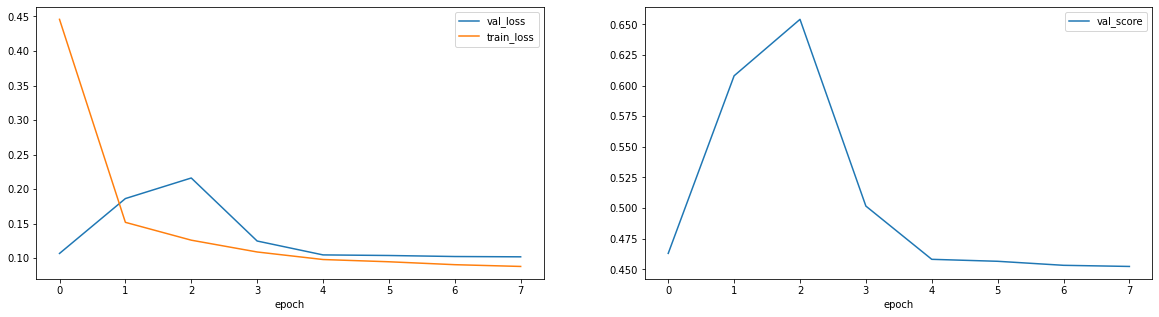

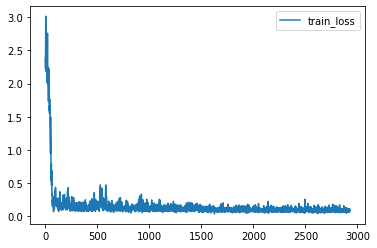

========== Fold 0 result ========== 

score: 0.452376  scores: [0.48497120250664594, 0.4457270441438699, 0.41369904506581145, 0.45549557092085796, 0.47229316339472055, 0.44206753273222177]
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model 

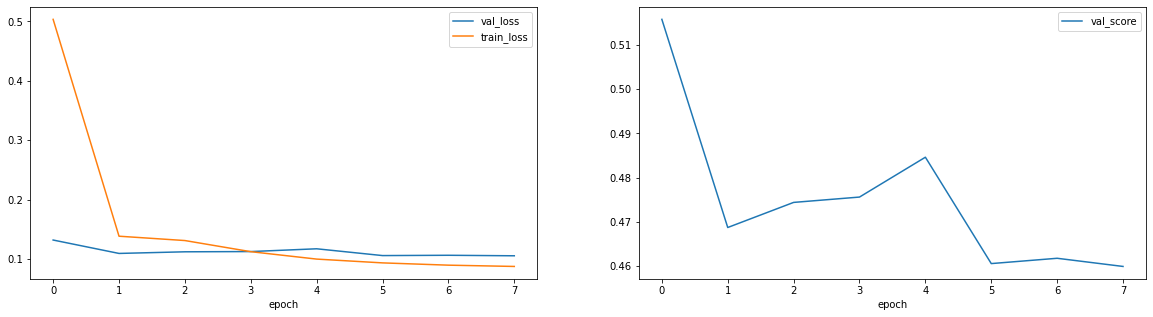

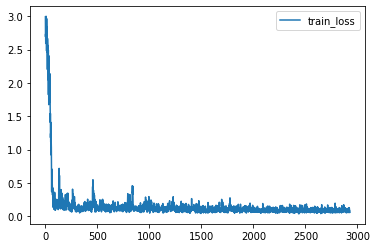

========== Fold 1 result ========== 

score: 0.459919  scores: [0.4933559105066691, 0.4557466004274931, 0.4248135972080778, 0.45570275535231997, 0.4773899403687707, 0.45250558346725134]
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model fro

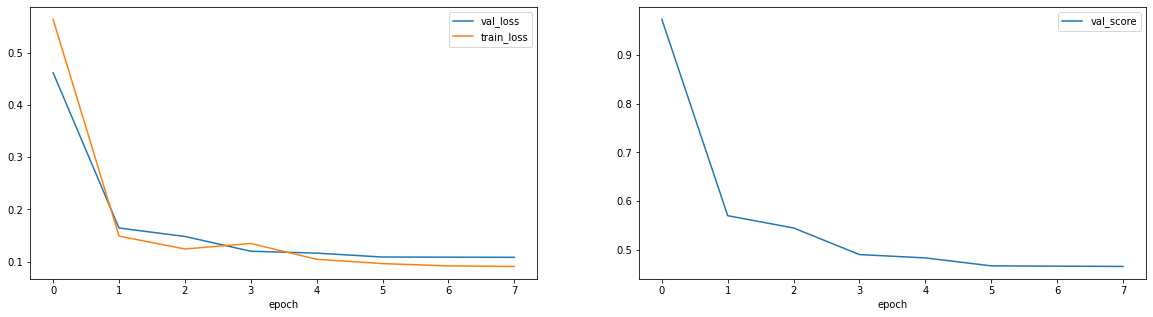

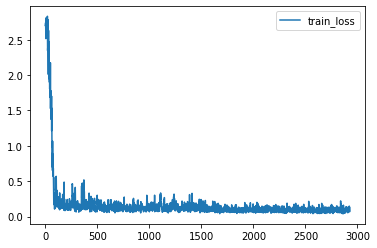

========== Fold 2 result ========== 

score: 0.466541  scores: [0.490689275890695, 0.45936342942846614, 0.424983071318502, 0.4741305467850405, 0.48761183383230033, 0.46246689522107015]
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from

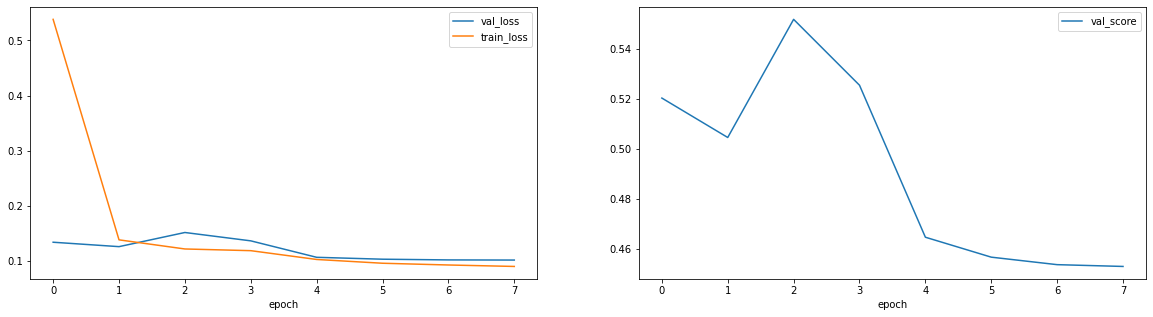

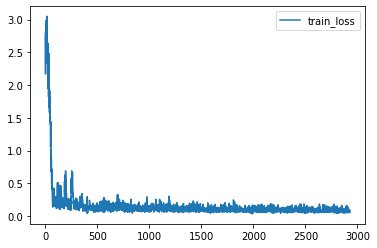

========== Fold 3 result ========== 

score: 0.453008  scores: [0.4872486375188646, 0.45114103514155646, 0.41510926145702826, 0.4461727316842062, 0.4750720298677567, 0.44330285437009975]
========== OOF Cross Validation ==========
score: 0.458009  scores: [0.48907566446557393, 0.45302263310581053, 0.4196830267898113, 0.45798832778271403, 0.4781269291351607, 0.45015994143020444]


In [18]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df[CFG.target_cols].values
        preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
        score, scores = mc_rmse(labels, preds)
        LOGGER.info(f'score: {score:<.6f}  scores: {scores}')
  
    oof_df = pd.DataFrame()
    history_df = pd.DataFrame()
    for fold in range(CFG.n_fold):
        if fold in CFG.trn_fold:
            model = WeightedAttentionModel(CFG, config_path=None, pretrained=True)

            fold_oof_df, fold_history_df = train_loop(CFG, model, train, fold)
            oof_df = pd.concat([oof_df, fold_oof_df])
            history_df = pd.concat([history_df, fold_history_df])
            LOGGER.info(f'========== Fold {fold} result ========== \n')
            get_result(fold_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    LOGGER.info(f'========== OOF Cross Validation ==========')
    get_result(oof_df)

    oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
    history_df.to_csv(OUTPUT_DIR+'history.csv', index=True)

* attention: `0.464`
* attention_v2: `0.464`
* attention_v3: `0.460`
* attention_v4: `0.458`
    * fold1 score: `0.4578`
* weighted_attention
    * encoder_lr=1e-5, epochs=8, llrd=0.8
        * fold0 score: `0.4560`
        * fold1 score: `0.4638`   `scores: [0.4949585842246235, 0.4577407508361864, 0.42117825505017215, 0.4581815172907474, 0.49150926589991156, 0.4591932190095764]`
    * encoder_lr=2e-5, epochs=8, llrd=0.8
        * fold1 score: `0.4510`    `scores: [0.48136674627311693, 0.44738289004759124, 0.4127942105681503, 0.456883896106838, 0.46830831884396334, 0.43937113025778607]`
    * **encoder_lr=3e-5, epochs=8, llrd=0.8**
        * fold0 score: `0.4516`
        * fold1 score: `0.4540`  `scores: [0.4853264684653544, 0.44859589160423835, 0.41415435431674336, 0.4547790040042994, 0.47097607810533054, 0.4501932505123217]`
        * fold2 score: `0.461941`  `scores: [0.4847134056577515, 0.451623164320167, 0.42323170478485955, 0.4712134463477466, 0.48428235834292177, 0.456583289966933]`
    * encoder_lr=3e-5, epochs=6, llrd=0.8
        * fold0 score: `0.4528`  `scores: [0.4848953462815002, 0.44811122495152267, 0.4149716726893011, 0.4583807011424279, 0.46970952282382056, 0.4411977697450286]`
        * fold1 score: `0.4570`  `scores: [0.48810675698034334, 0.4528429480197457, 0.41720959663136997, 0.4562767641078842, 0.47572345866809645, 0.4523055600989927]`
        * fold2 `score: 0.465653`  `scores: [0.48929153514945717, 0.4542827606470322, 0.42856059823173825, 0.47702867561025536, 0.4841350154934882, 0.4606187782953733]`

In [19]:
!zip -r output.zip ./

  adding: fold0.png (deflated 20%)
  adding: microsoft-deberta-v3-base_fold2_best.pth (deflated 23%)
  adding: config.pth (deflated 49%)
  adding: fold2_train_loss.png (deflated 13%)
  adding: fold0_train_loss.png (deflated 14%)
  adding: __notebook__.ipynb (deflated 94%)
  adding: oof_df.pkl (deflated 69%)
  adding: inference.log (deflated 82%)
  adding: microsoft-deberta-v3-base_fold3_best.pth (deflated 23%)
  adding: CFG.json (deflated 50%)
  adding: tokenizer/ (stored 0%)
  adding: tokenizer/tokenizer_config.json (deflated 45%)
  adding: tokenizer/tokenizer.json (deflated 77%)
  adding: tokenizer/spm.model (deflated 50%)
  adding: tokenizer/added_tokens.json (stored 0%)
  adding: tokenizer/special_tokens_map.json (deflated 54%)
  adding: microsoft-deberta-v3-base_fold0_best.pth (deflated 23%)
  adding: fold2.png (deflated 26%)
  adding: fold3.png (deflated 25%)
  adding: fold1.png (deflated 24%)
  adding: fold1_train_loss.png (deflated 14%)
  adding: fold3_train_loss.png (deflated 